In [1]:
import numpy as np
import torch
import json
import os

from torch_geometric.data   import Data, Batch
from torch_geometric.loader import DataLoader
from libraries.model        import nGCNN, eGCNN, diffusion_step, get_graph_losses, add_features_to_graph

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [2]:
# Based on adding and removing noise to graphs
# The models is able to learn hidden patterns
# It can be conditionally trained with respect to some target property

In [3]:
# Define name of data folder where reference dataset are contained
# It shall be consistent with data_folder and data will be moved to models folder
data_name = 'GM_BiSI_diffraction'

# Define folder in which data is stored
data_folder   = f'data/{data_name}'

# The folder is named as target_folder_vi (eg, target_folder_v0)
general_folder = f'models/{data_name}'
if not os.path.exists(general_folder):
    # Generate new folder
    os.system(f'mkdir {general_folder}')

# Each new run generates a new folder, with different generations and training most likely (as data might vary as well)
i = 0
while True:
    target_folder = f'{general_folder}/GM_v{i}'
    if not os.path.exists(target_folder):
        # Copy all data
        os.system(f'cp -r {data_folder} {target_folder}')
        break
    i += 1

edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

In [4]:
# Machine-learning parameters
n_epochs      = 3000
batch_size    = 32
learning_rate = 0.0001

# Number of diffusing and denoising steps
n_t_steps = 5

# Decay of parameter alpha
noise_contribution = 0.05
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Create and save as a dictionary
model_parameters = {
    'data_folder':        data_folder,
    'n_epochs':           n_epochs,
    'batch_size':         batch_size,
    'learning_rate':      learning_rate,
    'n_t_steps':          n_t_steps,
    'noise_contribution': noise_contribution,
    'dropout_node':       dropout_node,
    'dropout_edge':       dropout_edge
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Load of graph database for training

Load the dataset, already standardized.

In [5]:
train_dataset_name_std      = f'{target_folder}/train_dataset.pt'
test_dataset_name_std       = f'{target_folder}/test_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

# Load the standardized dataset, with corresponding labels and parameters
train_dataset = torch.load(train_dataset_name_std)
test_dataset  = torch.load(test_dataset_name_std)

# Load the data from the JSON file
with open(dataset_parameters_name_std, 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert NumPy arrays back to PyTorch tensors
dataset_parameters = {key: torch.tensor(value) for key, value in numpy_dict.items()}

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']

# Training of the model

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, pin_memory=True)

In [7]:
# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features + 1

# Determine the number of graph-level features to be predicted
n_graph_features = len(train_dataset[0].y)

# Instantiate the models for nodes and edges
node_model = nGCNN(n_node_features, n_graph_features, dropout_node).to(device)
edge_model = eGCNN(n_node_features, n_graph_features, dropout_edge).to(device)

# Moving models to device
node_model = node_model.to(device)
edge_model = edge_model.to(device)

# Load previous model if available
try:
    # Load model state
    node_model.load_state_dict(torch.load(node_model_name))
    edge_model.load_state_dict(torch.load(edge_model_name))
    
    # Evaluate model state
    node_model.eval()
    edge_model.eval()
except FileNotFoundError:
    pass

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(905, 256)
  (conv2): GraphConv(256, 5)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=906, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)


In [53]:
# Loss factor for normalization
loss_factor = len(train_dataset) * n_t_steps

# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Training loop
total_losses = []
edge_losses  = []
node_losses  = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    total_loss_cum = 0
    edge_loss_cum  = 0
    node_loss_cum  = 0
    for batch_0 in train_loader:  # train_loader
        #print()
        # Move batch data to GPU
        g_batch_0 = batch_0.to(device)
        
        batch_size_0 = batch_0.num_graphs
        
        # Save graph-level embedding
        embedding_batch_0 = []
        for idx in range(batch_size_0):
            embedding_batch_0.append(g_batch_0[idx].y.detach().to(device))
        
        # Initialize the gradient of the optimizers
        node_optimizer.zero_grad()
        edge_optimizer.zero_grad()
        
        # Start denoising-diffusing process
        for t_step in np.arange(1, n_t_steps+1):
            # Diffuse the graph with some noise
            #print()
            #print(f'Step: {t_step}')
            #print('Diffusing...')
            
            g_batch_t = []
            e_batch_t = []
            for idx in range(batch_size_0):
                graph_t, epsilon_t = diffusion_step(g_batch_0[idx], t_step, n_t_steps, alpha_decay)
                g_batch_t.append(graph_t)
                e_batch_t.append(epsilon_t)
            
            # Update diffused graph as next one
            for idx in range(batch_size_0):
                g_batch_0[idx] = g_batch_t[idx].clone()

            # Denoise the diffused graph
            #print(f'Denoising...')
            
            # Add graph-level embedding to graph_t as node embeddings
            for idx in range(batch_size_0):
                g_batch_t[idx] = add_features_to_graph(g_batch_t[idx],
                                                       embedding_batch_0[idx])  # To match graph.y shape
            
            # Add t_step information to graph_t as node embeddings
            t_step_std = torch.tensor([t_step/n_t_steps - 0.5], dtype=torch.float).to(device)  # Standard normalization
            for idx in range(batch_size_0):
                g_batch_t[idx] = add_features_to_graph(g_batch_t[idx],
                                                       t_step_std)  # To match graph.y shape, which is 1D
            
            # Generate batch objects
            g_batch_t = Batch.from_data_list(g_batch_t)
            e_batch_t = Batch.from_data_list(e_batch_t)
            
            # Move data to device
            g_batch_t = g_batch_t.to(device)
            e_batch_t = e_batch_t.to(device)
            
            # Perform a single forward pass for predicting node features
            out_x = node_model(g_batch_t.x,
                               g_batch_t.edge_index,
                               g_batch_t.edge_attr)
            
            # Remove t_step information
            out_x = out_x[:, :-1]

            # Define x_i and x_j as features of every corresponding pair of nodes (same order than attributes)
            x_i = g_batch_t.x[g_batch_t.edge_index[0]]
            x_j = g_batch_t.x[g_batch_t.edge_index[1]]

            # Perform a single forward pass for predicting edge attributes
            # Introduce previous edge attributes as features as well
            out_attr = edge_model(x_i, x_j, g_batch_t.edge_attr)

            # Moving data to device
            out_x    =    out_x.to(device)
            out_attr = out_attr.to(device)
            
            # Construct noise graph with predicted node features and edge attributes, and previous edge indexes
            pred_epsilon_t = Data(x=out_x,
                                  edge_index=g_batch_t.edge_index,
                                  edge_attr=out_attr.ravel())
            
            # Backpropagation and optimization step
            #print('Backpropagating...')

            # Calculate the loss for node features and edge attributes
            node_loss, edge_loss = get_graph_losses(e_batch_t, pred_epsilon_t, batch_size_0)
            
            # Backpropagate and optimize node loss
            node_loss.backward(retain_graph=True)
            node_optimizer.step()

            # Backpropagate and optimize edge loss
            edge_loss.backward(retain_graph=True)
            edge_optimizer.step()

            # Accumulate the total training loss
            loss = node_loss + edge_loss
            
            # Get items
            total_loss_cum += loss.item()
            edge_loss_cum  += edge_loss.item()
            node_loss_cum  += node_loss.item()
    
    # Compute the average train loss
    total_loss_cum /= loss_factor
    edge_loss_cum  /= loss_factor
    node_loss_cum  /= loss_factor
    
    # Append average losses
    total_losses.append(total_loss_cum)
    edge_losses.append(edge_loss_cum)
    node_losses.append(node_loss_cum)
    
    print(f'Epoch: {epoch+1}, total loss: {total_loss_cum:.4f}, edge loss: {edge_loss_cum:.4f}, node loss: {node_loss_cum:.4f}')
    
    # Save some checkpoints
    if (epoch % 20) == 0:
        torch.save(node_model.state_dict(), node_model_name)
        torch.save(edge_model.state_dict(), edge_model_name)

torch.save(node_model.state_dict(), node_model_name)
torch.save(edge_model.state_dict(), edge_model_name)

Epoch: 1, total loss: 0.5390, edge loss: 0.0012, node loss: 0.5378
Epoch: 2, total loss: 2.9503, edge loss: 0.0012, node loss: 2.9491
Epoch: 3, total loss: 2.1674, edge loss: 0.0012, node loss: 2.1662
Epoch: 4, total loss: 1.3421, edge loss: 0.0012, node loss: 1.3410
Epoch: 5, total loss: 2.4496, edge loss: 0.0012, node loss: 2.4485
Epoch: 6, total loss: 0.5341, edge loss: 0.0012, node loss: 0.5329
Epoch: 7, total loss: 0.9642, edge loss: 0.0012, node loss: 0.9631
Epoch: 8, total loss: 1.6135, edge loss: 0.0012, node loss: 1.6123
Epoch: 9, total loss: 1.3995, edge loss: 0.0012, node loss: 1.3984
Epoch: 10, total loss: 1.2522, edge loss: 0.0012, node loss: 1.2510
Epoch: 11, total loss: 1.3116, edge loss: 0.0012, node loss: 1.3104
Epoch: 12, total loss: 0.8269, edge loss: 0.0012, node loss: 0.8258
Epoch: 13, total loss: 0.3250, edge loss: 0.0012, node loss: 0.3239
Epoch: 14, total loss: 0.3435, edge loss: 0.0012, node loss: 0.3424
Epoch: 15, total loss: 0.8848, edge loss: 0.0012, node lo

KeyboardInterrupt: 

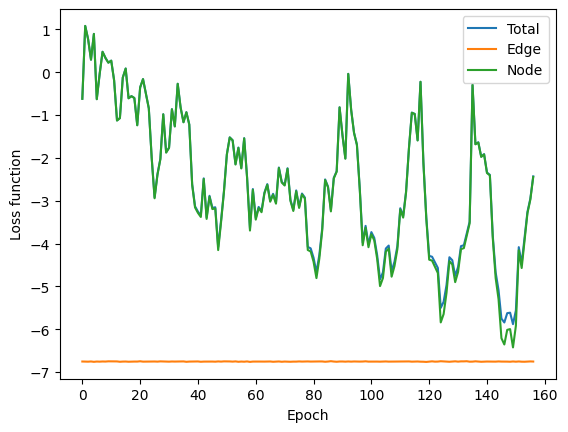

In [54]:
import matplotlib.pyplot as plt 
plt.plot(np.log(total_losses), label='Total')
plt.plot(np.log(edge_losses),  label='Edge')
plt.plot(np.log(node_losses),  label='Node')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()